In [1]:
# ============================================================================
# PART 2: SUPERVISED REGIME PREDICTION
# ============================================================================
# Author: heilo
# Description: Train XGBoost to predict future market regimes
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import xgboost as xgb

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("=" * 70)
print("SUPERVISED REGIME PREDICTION")
print("Part 2: XGBoost Classification")
print("=" * 70)
print(f"\nAnalysis Start Time: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")

print("\n" + "-" * 70)
print("STEP 1: LOAD REGIME DATA")
print("-" * 70)

# Load the regime data from Part 1
df = pd.read_csv('../data/regime_data.csv', index_col=0, parse_dates=True)

print(f"\n✓ Loaded data: {df.shape}")
print(f"✓ Date range: {df.index[0].date()} to {df.index[-1].date()}")
print(f"✓ Total trading days: {len(df)}")

# Display regime distribution
print("\n" + "-" * 70)
print("CURRENT REGIME DISTRIBUTION")
print("-" * 70)
regime_counts = df['Regime'].value_counts().sort_index()
for regime, count in regime_counts.items():
    pct = count / len(df) * 100
    print(f"  Regime {regime}: {count:4d} days ({pct:5.2f}%)")

print("\nFirst few rows:")
print(df.head())

SUPERVISED REGIME PREDICTION
Part 2: XGBoost Classification

Analysis Start Time: 2025-10-21 19:10:39

----------------------------------------------------------------------
STEP 1: LOAD REGIME DATA
----------------------------------------------------------------------

✓ Loaded data: (2408, 32)
✓ Date range: 2016-07-29 to 2025-10-21
✓ Total trading days: 2408

----------------------------------------------------------------------
CURRENT REGIME DISTRIBUTION
----------------------------------------------------------------------
  Regime 0: 1363 days (56.60%)
  Regime 1:  289 days (12.00%)
  Regime 2:  227 days ( 9.43%)
  Regime 3:  529 days (21.97%)

First few rows:
                                   Open         High          Low  \
2016-07-29 19:05:28.472034  3307.603386  3366.354569  3282.327118   
2016-08-01 19:05:28.472034  3280.005529  3282.649205  3251.266975   
2016-08-02 19:05:28.472034  3292.017889  3319.442244  3268.663289   
2016-08-03 19:05:28.472034  3309.420405  3339.714

In [2]:
print("\n" + "-" * 70)
print("STEP 2: CREATE PREDICTION TARGET")
print("-" * 70)

# Create target: predict next day's regime
df['Target_Regime'] = df['Regime'].shift(-1)

# Remove last row (no target available)
df_model = df[:-1].copy()

print(f"\n✓ Created target variable: Next day's regime")
print(f"✓ Dataset size after removing last row: {len(df_model)}")

# Check for class balance
print("\n" + "-" * 70)
print("TARGET REGIME DISTRIBUTION")
print("-" * 70)
target_counts = df_model['Target_Regime'].value_counts().sort_index()
for regime, count in target_counts.items():
    pct = count / len(df_model) * 100
    print(f"  Regime {int(regime)}: {count:4d} days ({pct:5.2f}%)")

# Visualize regime transitions
print("\n✓ Analyzing regime persistence...")
same_regime = (df_model['Regime'] == df_model['Target_Regime']).sum()
regime_persistence = same_regime / len(df_model) * 100
print(f"✓ Regime persistence rate: {regime_persistence:.2f}%")
print(f"  (Market stays in same regime {regime_persistence:.1f}% of the time)")


----------------------------------------------------------------------
STEP 2: CREATE PREDICTION TARGET
----------------------------------------------------------------------

✓ Created target variable: Next day's regime
✓ Dataset size after removing last row: 2407

----------------------------------------------------------------------
TARGET REGIME DISTRIBUTION
----------------------------------------------------------------------
  Regime 0: 1363 days (56.63%)
  Regime 1:  289 days (12.01%)
  Regime 2:  227 days ( 9.43%)
  Regime 3:  528 days (21.94%)

✓ Analyzing regime persistence...
✓ Regime persistence rate: 79.48%
  (Market stays in same regime 79.5% of the time)


In [3]:
print("\n" + "-" * 70)
print("STEP 3: FEATURE ENGINEERING FOR PREDICTION")
print("-" * 70)

# Select features for prediction (exclude target and regime info)
feature_cols = [
    # Returns and volatility
    'Returns', 'Log_Returns',
    'Volatility_5', 'Volatility_21', 'Volatility_63',
    
    # Volume
    'Volume_Ratio',
    
    # Trend indicators
    'Price_to_SMA20', 'Price_to_SMA50', 'Price_to_SMA200',
    
    # Momentum indicators
    'RSI_14', 'MACD', 'MACD_Signal', 'MACD_Hist',
    
    # Bollinger Bands
    'BB_Width', 'BB_Position',
    
    # Higher moments
    'Skew_21', 'Kurt_21',
    
    # Current regime (as a feature)
    'Regime'
]

print(f"\nUsing {len(feature_cols)} features for prediction:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

# Extract features and target
X = df_model[feature_cols].values
y = df_model['Target_Regime'].values.astype(int)

print(f"\n✓ Feature matrix shape: {X.shape}")
print(f"✓ Target vector shape: {y.shape}")
print(f"✓ Number of classes: {len(np.unique(y))}")


----------------------------------------------------------------------
STEP 3: FEATURE ENGINEERING FOR PREDICTION
----------------------------------------------------------------------

Using 18 features for prediction:
   1. Returns
   2. Log_Returns
   3. Volatility_5
   4. Volatility_21
   5. Volatility_63
   6. Volume_Ratio
   7. Price_to_SMA20
   8. Price_to_SMA50
   9. Price_to_SMA200
  10. RSI_14
  11. MACD
  12. MACD_Signal
  13. MACD_Hist
  14. BB_Width
  15. BB_Position
  16. Skew_21
  17. Kurt_21
  18. Regime

✓ Feature matrix shape: (2407, 18)
✓ Target vector shape: (2407,)
✓ Number of classes: 4


In [4]:
print("\n" + "-" * 70)
print("STEP 4: TRAIN-TEST SPLIT (TIME-SERIES AWARE)")
print("-" * 70)

# Time-series split: use first 80% for training, last 20% for testing
split_idx = int(len(X) * 0.8)

X_train = X[:split_idx]
X_test = X[split_idx:]
y_train = y[:split_idx]
y_test = y[split_idx:]

# Get corresponding dates
train_dates = df_model.index[:split_idx]
test_dates = df_model.index[split_idx:]

print(f"\nTraining set:")
print(f"  Size: {len(X_train)} samples")
print(f"  Date range: {train_dates[0].date()} to {train_dates[-1].date()}")

print(f"\nTest set:")
print(f"  Size: {len(X_test)} samples")
print(f"  Date range: {test_dates[0].date()} to {test_dates[-1].date()}")

# Check class distribution in train/test
print("\n" + "-" * 70)
print("CLASS DISTRIBUTION")
print("-" * 70)

train_dist = pd.Series(y_train).value_counts().sort_index()
test_dist = pd.Series(y_test).value_counts().sort_index()

print("\nTraining set:")
for regime, count in train_dist.items():
    pct = count / len(y_train) * 100
    print(f"  Regime {regime}: {count:4d} ({pct:5.2f}%)")

print("\nTest set:")
for regime, count in test_dist.items():
    pct = count / len(y_test) * 100
    print(f"  Regime {regime}: {count:4d} ({pct:5.2f}%)")


----------------------------------------------------------------------
STEP 4: TRAIN-TEST SPLIT (TIME-SERIES AWARE)
----------------------------------------------------------------------

Training set:
  Size: 1925 samples
  Date range: 2016-07-29 to 2023-12-14

Test set:
  Size: 482 samples
  Date range: 2023-12-15 to 2025-10-20

----------------------------------------------------------------------
CLASS DISTRIBUTION
----------------------------------------------------------------------

Training set:
  Regime 0:  992 (51.53%)
  Regime 1:  288 (14.96%)
  Regime 2:  213 (11.06%)
  Regime 3:  432 (22.44%)

Test set:
  Regime 0:  371 (76.97%)
  Regime 1:    1 ( 0.21%)
  Regime 2:   14 ( 2.90%)
  Regime 3:   96 (19.92%)



----------------------------------------------------------------------
STEP 5: TRAIN XGBOOST CLASSIFIER
----------------------------------------------------------------------

XGBoost Configuration:
  objective                : multi:softprob
  num_class                : 4
  max_depth                : 6
  learning_rate            : 0.1
  n_estimators             : 200
  subsample                : 0.8
  colsample_bytree         : 0.8
  random_state             : 42
  eval_metric              : mlogloss
  early_stopping_rounds    : 20
  tree_method              : hist

----------------------------------------------------------------------
Training XGBoost model...
----------------------------------------------------------------------

✓ Training completed!
✓ Best iteration: 82
✓ Number of trees used: 200

----------------------------------------------------------------------
TOP 10 MOST IMPORTANT FEATURES
----------------------------------------------------------------------
  Regime   

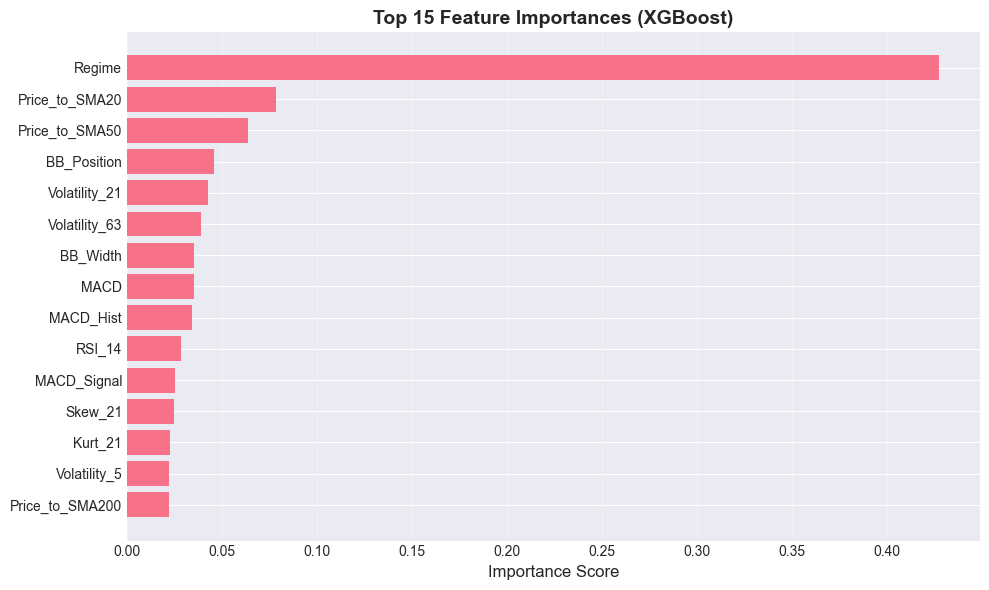


✓ Feature importance analysis complete!


In [5]:
print("\n" + "-" * 70)
print("STEP 5: TRAIN XGBOOST CLASSIFIER")
print("-" * 70)

# XGBoost parameters
params = {
    'objective': 'multi:softprob',
    'num_class': len(np.unique(y)),
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'eval_metric': 'mlogloss',
    'early_stopping_rounds': 20,
    'tree_method': 'hist'
}

print("\nXGBoost Configuration:")
for key, value in params.items():
    print(f"  {key:25s}: {value}")

# Train model
print("\n" + "-" * 70)
print("Training XGBoost model...")
print("-" * 70)

model = xgb.XGBClassifier(**params)

# Train with validation set for early stopping
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(
    X_train, y_train,
    eval_set=eval_set,
    verbose=False
)

print(f"\n✓ Training completed!")
print(f"✓ Best iteration: {model.best_iteration}")
print(f"✓ Number of trees used: {model.n_estimators}")

# Feature importance
print("\n" + "-" * 70)
print("TOP 10 MOST IMPORTANT FEATURES")
print("-" * 70)

feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

for i, row in feature_importance.head(10).iterrows():
    print(f"  {row['Feature']:20s}: {row['Importance']:.4f}")

# Visualize feature importance
fig, ax = plt.subplots(figsize=(10, 6))
top_features = feature_importance.head(15)
ax.barh(range(len(top_features)), top_features['Importance'].values)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'].values)
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_title('Top 15 Feature Importances (XGBoost)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n✓ Feature importance analysis complete!")


----------------------------------------------------------------------
STEP 6: MODEL EVALUATION
----------------------------------------------------------------------

OVERALL ACCURACY

Training Accuracy:   99.64%
Test Accuracy:       92.95%

CLASSIFICATION REPORT (TEST SET)

               precision    recall  f1-score   support

    Regime 0       0.95      0.97      0.96       371
    Regime 1       0.00      0.00      0.00         1
    Regime 2       0.80      0.86      0.83        14
    Regime 3       0.85      0.80      0.82        96

    accuracy                           0.93       482
   macro avg       0.65      0.66      0.65       482
weighted avg       0.93      0.93      0.93       482


----------------------------------------------------------------------
PER-REGIME METRICS (TEST SET)
----------------------------------------------------------------------

  Regime  Precision   Recall  F1-Score  Support
      0   0.954787 0.967655  0.961178      371
      1   0.00000

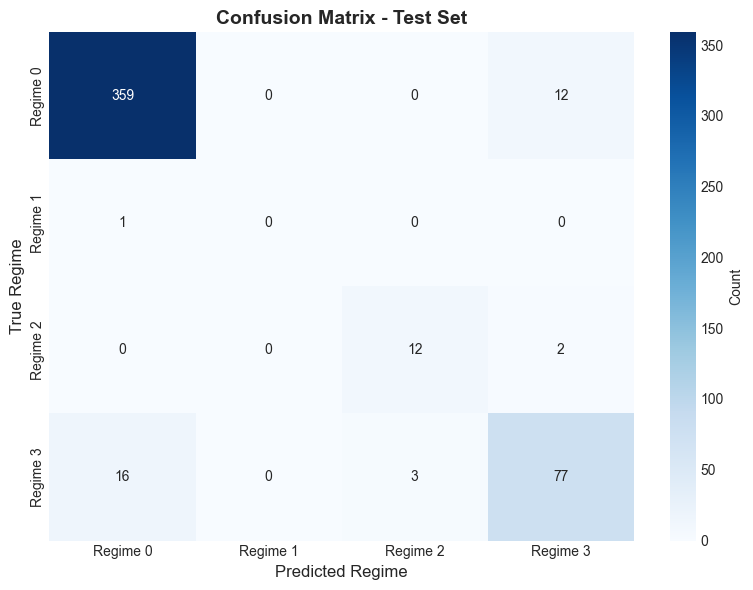


✓ Model evaluation complete!


In [6]:
print("\n" + "-" * 70)
print("STEP 6: MODEL EVALUATION")
print("-" * 70)

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Get prediction probabilities
y_train_proba = model.predict_proba(X_train)
y_test_proba = model.predict_proba(X_test)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("\n" + "=" * 70)
print("OVERALL ACCURACY")
print("=" * 70)
print(f"\nTraining Accuracy:   {train_accuracy:.2%}")
print(f"Test Accuracy:       {test_accuracy:.2%}")

# Detailed classification report
print("\n" + "=" * 70)
print("CLASSIFICATION REPORT (TEST SET)")
print("=" * 70)
print("\n", classification_report(y_test, y_test_pred, 
                                  target_names=[f'Regime {i}' for i in range(len(np.unique(y)))]))

# Per-class metrics
print("\n" + "-" * 70)
print("PER-REGIME METRICS (TEST SET)")
print("-" * 70)

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_test_pred)

metrics_df = pd.DataFrame({
    'Regime': range(len(np.unique(y))),
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("\n", metrics_df.to_string(index=False))

# Confusion matrix
print("\n" + "-" * 70)
print("CONFUSION MATRIX (TEST SET)")
print("-" * 70)

cm = confusion_matrix(y_test, y_test_pred)
print("\n", cm)

# Visualize confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
           xticklabels=[f'Regime {i}' for i in range(len(np.unique(y)))],
           yticklabels=[f'Regime {i}' for i in range(len(np.unique(y)))],
           cbar_kws={'label': 'Count'})
ax.set_xlabel('Predicted Regime', fontsize=12)
ax.set_ylabel('True Regime', fontsize=12)
ax.set_title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✓ Model evaluation complete!")


----------------------------------------------------------------------
STEP 7: PREDICTION CONFIDENCE ANALYSIS
----------------------------------------------------------------------

Training set confidence:
  Mean: 91.31%
  Std:  10.13%
  Min:  44.21%
  Max:  99.73%

Test set confidence:
  Mean: 93.28%
  Std:  9.25%
  Min:  49.83%
  Max:  99.65%

----------------------------------------------------------------------
ACCURACY BY CONFIDENCE LEVEL (TEST SET)
----------------------------------------------------------------------
  Medium (40-60%)     : 85.71% (   7 predictions,  1.45%)
  High (60-80%)       : 68.29% (  41 predictions,  8.51%)
  Very High (80-100%) : 95.39% ( 434 predictions, 90.04%)


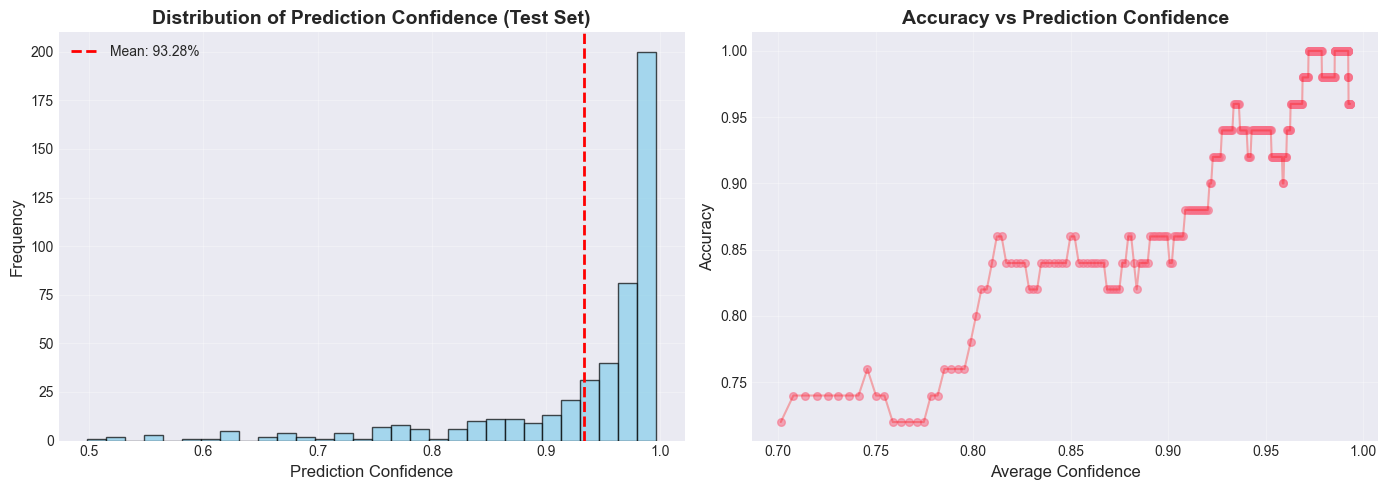


✓ Confidence analysis complete!


In [7]:
print("\n" + "-" * 70)
print("STEP 7: PREDICTION CONFIDENCE ANALYSIS")
print("-" * 70)

# Get maximum probability for each prediction (confidence)
train_confidence = y_train_proba.max(axis=1)
test_confidence = y_test_proba.max(axis=1)

print(f"\nTraining set confidence:")
print(f"  Mean: {train_confidence.mean():.2%}")
print(f"  Std:  {train_confidence.std():.2%}")
print(f"  Min:  {train_confidence.min():.2%}")
print(f"  Max:  {train_confidence.max():.2%}")

print(f"\nTest set confidence:")
print(f"  Mean: {test_confidence.mean():.2%}")
print(f"  Std:  {test_confidence.std():.2%}")
print(f"  Min:  {test_confidence.min():.2%}")
print(f"  Max:  {test_confidence.max():.2%}")

# Analyze accuracy by confidence level
print("\n" + "-" * 70)
print("ACCURACY BY CONFIDENCE LEVEL (TEST SET)")
print("-" * 70)

confidence_bins = [0, 0.4, 0.6, 0.8, 1.0]
confidence_labels = ['Low (0-40%)', 'Medium (40-60%)', 'High (60-80%)', 'Very High (80-100%)']

test_conf_binned = pd.cut(test_confidence, bins=confidence_bins, labels=confidence_labels)

for label in confidence_labels:
    mask = test_conf_binned == label
    if mask.sum() > 0:
        acc = accuracy_score(y_test[mask], y_test_pred[mask])
        count = mask.sum()
        pct = count / len(y_test) * 100
        print(f"  {label:20s}: {acc:.2%} ({count:4d} predictions, {pct:5.2f}%)")

# Visualize confidence distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Confidence histogram
ax1.hist(test_confidence, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax1.axvline(test_confidence.mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {test_confidence.mean():.2%}')
ax1.set_xlabel('Prediction Confidence', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Prediction Confidence (Test Set)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy vs Confidence
confidence_sorted_idx = np.argsort(test_confidence)
window = 50
rolling_accuracy = []
rolling_confidence = []

for i in range(len(test_confidence) - window):
    idx = confidence_sorted_idx[i:i+window]
    rolling_accuracy.append(accuracy_score(y_test[idx], y_test_pred[idx]))
    rolling_confidence.append(test_confidence[idx].mean())

ax2.scatter(rolling_confidence, rolling_accuracy, alpha=0.6, s=30)
ax2.plot(rolling_confidence, rolling_accuracy, color='red', alpha=0.3)
ax2.set_xlabel('Average Confidence', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Accuracy vs Prediction Confidence', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Confidence analysis complete!")


----------------------------------------------------------------------
STEP 8: TEMPORAL PREDICTION ANALYSIS
----------------------------------------------------------------------

✓ Created results dataframe with 482 predictions


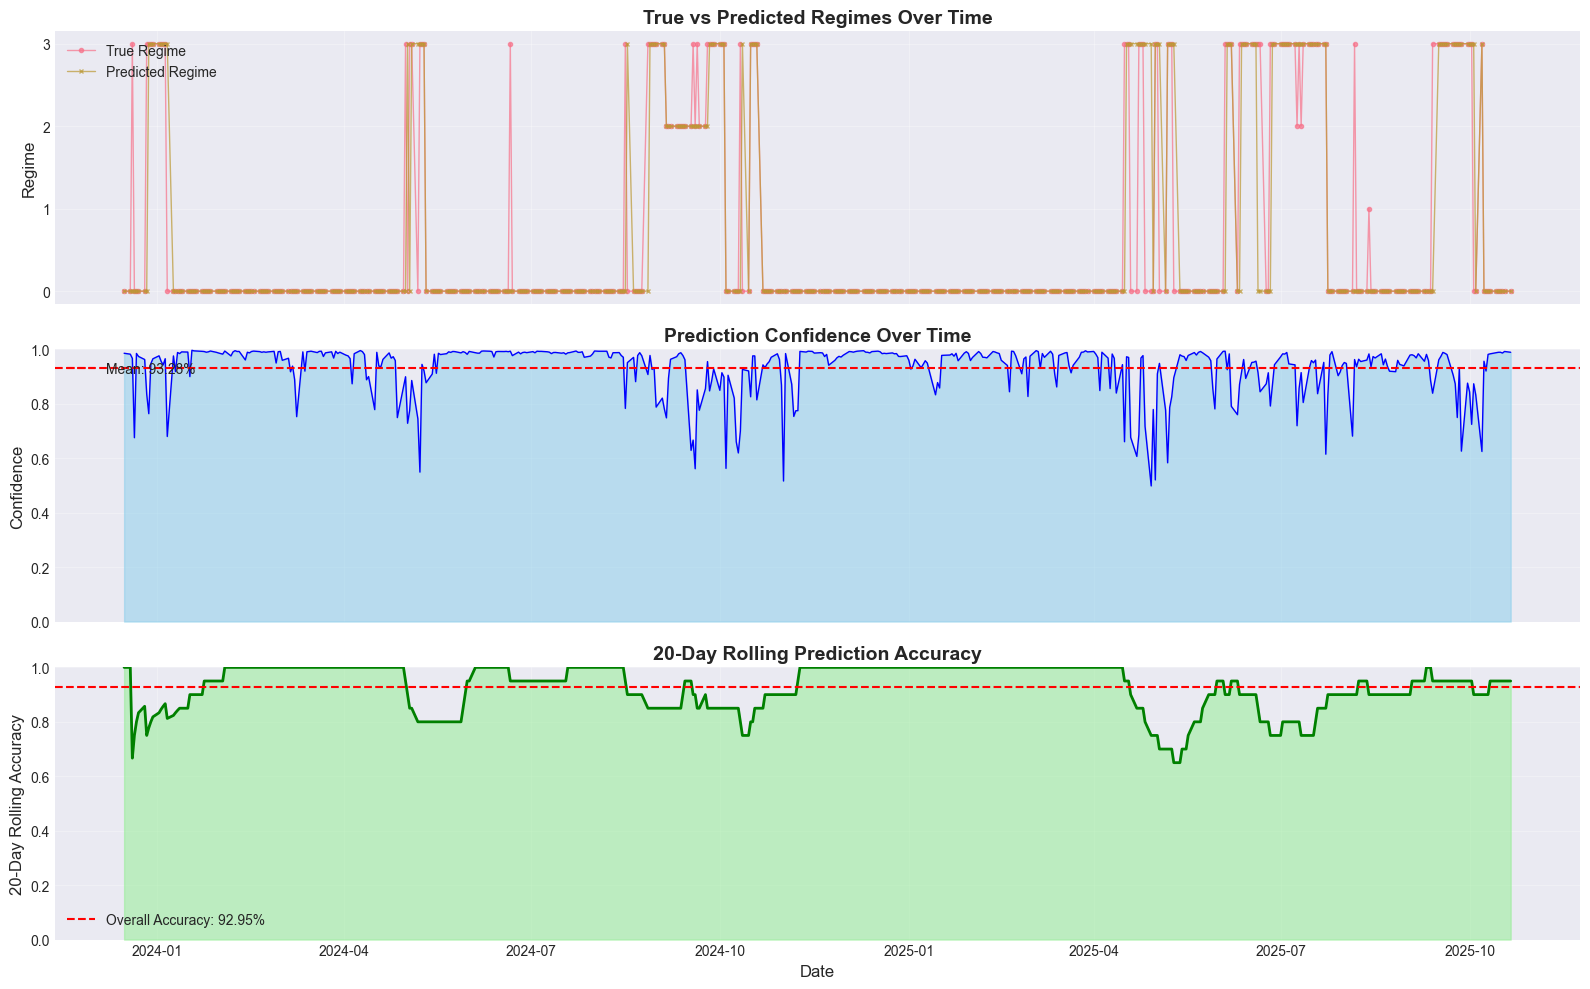


----------------------------------------------------------------------
MONTHLY ACCURACY BREAKDOWN
----------------------------------------------------------------------

            Accuracy  Predictions
YearMonth                       
2024-11    1.000000           21
2024-12    1.000000           22
2025-01    1.000000           23
2025-02    1.000000           20
2025-03    1.000000           21
2025-04    0.772727           22
2025-05    0.909091           22
2025-06    0.761905           21
2025-07    0.913043           23
2025-08    0.904762           21
2025-09    0.954545           22
2025-10    0.928571           14

✓ Temporal analysis complete!


In [8]:
print("\n" + "-" * 70)
print("STEP 8: TEMPORAL PREDICTION ANALYSIS")
print("-" * 70)

# Create DataFrame with predictions
results_df = pd.DataFrame({
    'Date': test_dates,
    'True_Regime': y_test,
    'Predicted_Regime': y_test_pred,
    'Confidence': test_confidence,
    'Correct': (y_test == y_test_pred).astype(int)
})

# Calculate rolling accuracy
window = 20
results_df['Rolling_Accuracy'] = results_df['Correct'].rolling(window=window, min_periods=1).mean()

print(f"\n✓ Created results dataframe with {len(results_df)} predictions")

# Visualize predictions over time
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

# 1. True vs Predicted Regimes
ax1.plot(results_df['Date'], results_df['True_Regime'], 
        label='True Regime', linewidth=1, alpha=0.7, marker='o', markersize=3)
ax1.plot(results_df['Date'], results_df['Predicted_Regime'], 
        label='Predicted Regime', linewidth=1, alpha=0.7, marker='x', markersize=3)
ax1.set_ylabel('Regime', fontsize=12)
ax1.set_title('True vs Predicted Regimes Over Time', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.set_yticks(range(len(np.unique(y))))

# 2. Prediction Confidence
ax2.fill_between(results_df['Date'], results_df['Confidence'], alpha=0.5, color='skyblue')
ax2.plot(results_df['Date'], results_df['Confidence'], linewidth=1, color='blue')
ax2.axhline(results_df['Confidence'].mean(), color='red', linestyle='--', 
           label=f"Mean: {results_df['Confidence'].mean():.2%}")
ax2.set_ylabel('Confidence', fontsize=12)
ax2.set_title('Prediction Confidence Over Time', fontsize=14, fontweight='bold')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 1])

# 3. Rolling Accuracy
ax3.fill_between(results_df['Date'], results_df['Rolling_Accuracy'], alpha=0.5, color='lightgreen')
ax3.plot(results_df['Date'], results_df['Rolling_Accuracy'], linewidth=2, color='green')
ax3.axhline(test_accuracy, color='red', linestyle='--', 
           label=f"Overall Accuracy: {test_accuracy:.2%}")
ax3.set_xlabel('Date', fontsize=12)
ax3.set_ylabel(f'{window}-Day Rolling Accuracy', fontsize=12)
ax3.set_title(f'{window}-Day Rolling Prediction Accuracy', fontsize=14, fontweight='bold')
ax3.legend(loc='lower left')
ax3.grid(True, alpha=0.3)
ax3.set_ylim([0, 1])

plt.tight_layout()
plt.show()

# Monthly accuracy analysis
print("\n" + "-" * 70)
print("MONTHLY ACCURACY BREAKDOWN")
print("-" * 70)

results_df['YearMonth'] = results_df['Date'].dt.to_period('M')
monthly_accuracy = results_df.groupby('YearMonth')['Correct'].agg(['mean', 'count'])
monthly_accuracy.columns = ['Accuracy', 'Predictions']

print("\n", monthly_accuracy.tail(12).to_string())

print("\n✓ Temporal analysis complete!")

In [9]:
print("\n" + "-" * 70)
print("STEP 9: SAVE MODEL AND RESULTS")
print("-" * 70)

import os

# Ensure data directory exists
data_dir = '../data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Save XGBoost model
model_path = os.path.join(data_dir, 'xgboost_regime_predictor.json')
model.save_model(model_path)
print(f"\n✓ Saved XGBoost model to: {model_path}")

# Save feature columns
feature_cols_path = os.path.join(data_dir, 'feature_columns.pkl')
with open(feature_cols_path, 'wb') as f:
    pickle.dump(feature_cols, f)
print(f"✓ Saved feature columns to: {feature_cols_path}")

# Save test results
results_path = os.path.join(data_dir, 'prediction_results.csv')
results_df.to_csv(results_path, index=False)
print(f"✓ Saved prediction results to: {results_path}")

# Save performance metrics
metrics = {
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy,
    'mean_confidence': test_confidence.mean(),
    'feature_importance': feature_importance.to_dict('records')
}

metrics_path = os.path.join(data_dir, 'model_metrics.pkl')
with open(metrics_path, 'wb') as f:
    pickle.dump(metrics, f)
print(f"✓ Saved performance metrics to: {metrics_path}")

# Summary statistics
print("\n" + "=" * 70)
print("MODEL PERFORMANCE SUMMARY")
print("=" * 70)
print(f"\nTraining Accuracy:        {train_accuracy:.2%}")
print(f"Test Accuracy:            {test_accuracy:.2%}")
print(f"Mean Prediction Confidence: {test_confidence.mean():.2%}")
print(f"\nTop 3 Features:")
for i, row in feature_importance.head(3).iterrows():
    print(f"  {i+1}. {row['Feature']:20s} ({row['Importance']:.4f})")

print("\n" + "=" * 70)
print("✓✓✓ PART 2 COMPLETE! ✓✓✓")
print("=" * 70)
print("\nYou have successfully:")
print("  ✓ Trained XGBoost to predict future regimes")
print(f"  ✓ Achieved {test_accuracy:.2%} test accuracy")
print("  ✓ Analyzed prediction confidence")
print("  ✓ Evaluated temporal performance")
print("  ✓ Saved all models and results")

print("\n" + "=" * 70)
print("NEXT STEP: PART 3 - ADAPTIVE TRADING STRATEGIES")
print("=" * 70)
print("\nCreate a new notebook: 03_adaptive_allocation.ipynb")
print("We'll build regime-based trading strategies and backtest them!")


----------------------------------------------------------------------
STEP 9: SAVE MODEL AND RESULTS
----------------------------------------------------------------------

✓ Saved XGBoost model to: ../data\xgboost_regime_predictor.json
✓ Saved feature columns to: ../data\feature_columns.pkl
✓ Saved prediction results to: ../data\prediction_results.csv
✓ Saved performance metrics to: ../data\model_metrics.pkl

MODEL PERFORMANCE SUMMARY

Training Accuracy:        99.64%
Test Accuracy:            92.95%
Mean Prediction Confidence: 93.28%

Top 3 Features:
  18. Regime               (0.4276)
  7. Price_to_SMA20       (0.0783)
  8. Price_to_SMA50       (0.0635)

✓✓✓ PART 2 COMPLETE! ✓✓✓

You have successfully:
  ✓ Trained XGBoost to predict future regimes
  ✓ Achieved 92.95% test accuracy
  ✓ Analyzed prediction confidence
  ✓ Evaluated temporal performance
  ✓ Saved all models and results

NEXT STEP: PART 3 - ADAPTIVE TRADING STRATEGIES

Create a new notebook: 03_adaptive_allocation.ipyn